In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing.tokenize_qwen import load_qwen_tokenizer, tokenize_df, expand_chunked_df

In [38]:
# 1. Load your JSONL file
data = "data/training_datasets/verified_GPThybrid.jsonl"
hybrid_df = pd.read_json(data, lines=True)
nocomment_df = pd.read_json("data/training_datasets/verified_nocomments.jsonl", lines=True)
nomod_df = pd.read_json("data/training_datasets/verified_nomods.jsonl", lines=True)
metrics_df = pd.read_csv("data/training_datasets/metrics.csv")
syntax_df = pd.read_json("data/training_datasets/syntax_check/GPThybrid.jsonl", lines=True)
# Keep only files that passed syntax check
hybrid_df = hybrid_df[hybrid_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
nocomment_df = nocomment_df[nocomment_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
nomod_df = nomod_df[nomod_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
metrics_df = metrics_df[metrics_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
# 2. Load tokenizer
tokenizer = load_qwen_tokenizer("Qwen/Qwen2.5-Coder-7B")

# 3. Tokenize
hybrid_tok_df = tokenize_df(hybrid_df, tokenizer)
nocomment_tok_df = tokenize_df(nocomment_df, tokenizer)
nomod_tok_df = tokenize_df(nomod_df, tokenizer)

metrics_df = metrics_df.merge(hybrid_tok_df[["filename", "n_tokens"]], on="filename", how="left")
metrics_df = metrics_df.rename(columns={"n_tokens": "hybrid_tokens"})
metrics_df = metrics_df.merge(nocomment_tok_df[["filename", "n_tokens"]], on="filename", how="left")
metrics_df = metrics_df.rename(columns={"n_tokens": "nocomment_tokens"})
metrics_df = metrics_df.merge(nomod_tok_df[["filename", "n_tokens"]], on="filename", how="left")
metrics_df = metrics_df.rename(columns={"n_tokens": "nomod_tokens"})



#print(hybrid_tok_df[["filename", "n_tokens"]].head())

# 4. Optional: Chunk for training
hybrid_chunk_df = expand_chunked_df(hybrid_tok_df, tokenizer, max_seq_len=4096, stride=256)
nocomment_chunk_df = expand_chunked_df(nocomment_tok_df, tokenizer, max_seq_len=4096, stride=256)
nomod_chunk_df = expand_chunked_df(nomod_tok_df, tokenizer, max_seq_len=4096, stride=256)
hybrid_chunk_df.head()



Token indices sequence length is longer than the specified maximum sequence length for this model (77160 > 32768). Running this sequence through the model will result in indexing errors


,filename,chunk_index,input_ids,n_tokens
0,cryptol/examples/splitAt.cry,0,"[87, 284, 508, 16, 11, 17, 11, 18, 11, 19, 60,...",69
1,cryptol/examples/AE.cry,0,"[3284, 36850, 315, 279, 25185, 504, 279, 5567,...",728
2,cryptol/examples/xor_cipher.cry,0,"[32826, 549, 314, 64, 25547, 5472, 264, 8, 589...",89
3,cryptol/examples/zero_weird.cry,0,"[87, 549, 314, 64, 92, 368, 589, 264, 1464, 50...",83
4,cryptol/examples/builtin_lifting.cry,0,"[322, 46239, 1330, 11893, 916, 45225, 11, 1298...",399


In [39]:
hybrid_tok_df.head()

,filename,filetype,content,variant,input_ids,n_tokens
0,cryptol/examples/splitAt.cry,cry,"x = [1,2,3,4] : [_][8]\n\ny = (splitAt x) : ([...",hybrid,"[87, 284, 508, 16, 11, 17, 11, 18, 11, 19, 60,...",69
1,cryptol/examples/AE.cry,cry,/*\nImplementation of the algorithms from the ...,hybrid,"[3284, 36850, 315, 279, 25185, 504, 279, 5567,...",728
2,cryptol/examples/xor_cipher.cry,cry,encrypt : {a}(fin a) => [8] -> [a][8] -> [a][8...,hybrid,"[32826, 549, 314, 64, 25547, 5472, 264, 8, 589...",89
3,cryptol/examples/zero_weird.cry,cry,x : {a}() => a -> [16]\nx v = zero v \n\nprope...,hybrid,"[87, 549, 314, 64, 92, 368, 589, 264, 1464, 50...",83
4,cryptol/examples/builtin_lifting.cry,cry,"//builtins lift over tuples, seqs, and records...",hybrid,"[322, 46239, 1330, 11893, 916, 45225, 11, 1298...",399


In [40]:
print(hybrid_chunk_df["n_tokens"].sum())
metrics_df.head()

773720


,filename,sha1,bytes,lines,avg_line_len,max_line_len,non_ascii_ratio,binary_like,enc_total_matched,enc_max_run,...,k_shingle,num_shingles,hexnum_ratio,num_tokens_model,junk_path,quality_ok,fail_reason,hybrid_tokens,nocomment_tokens,nomod_tokens
0,cryptol/examples/splitAt.cry,816e7cd6994a469bc9fb88ded8fea4f463a59e40,108,10,9.90,33,0.0,False,0,0,...,5,64,0.0,NaN,True,True,ok,69,69,69
1,cryptol/examples/AE.cry,05483796c6a8a4760cd335120b09c67c7ef1db78,2372,86,26.59,77,0.0,False,0,0,...,5,442,0.0,NaN,True,True,ok,728,490,759
2,cryptol/examples/xor_cipher.cry,e0f950dcd057b865153df435205bb95decfde4e0,264,7,36.86,56,0.0,False,0,0,...,5,92,0.0,NaN,True,True,ok,89,89,89
3,cryptol/examples/zero_weird.cry,d9a57173f1d3d0e9177212dba96b6e625a154551,163,13,11.62,31,0.0,False,0,0,...,5,62,0.0,NaN,True,True,ok,83,83,83
4,cryptol/examples/builtin_lifting.cry,c491ba67bacc44f7be36b518a183ea8a89279c4b,1133,49,22.14,93,0.0,False,0,0,...,5,280,0.0,NaN,True,True,ok,399,286,399


In [41]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   filename           697 non-null    object 
 1   sha1               697 non-null    object 
 2   bytes              697 non-null    int64  
 3   lines              697 non-null    int64  
 4   avg_line_len       697 non-null    float64
 5   max_line_len       697 non-null    int64  
 6   non_ascii_ratio    697 non-null    float64
 7   binary_like        697 non-null    bool   
 8   enc_total_matched  697 non-null    int64  
 9   enc_max_run        697 non-null    int64  
 10  enc_fraction       697 non-null    float64
 11  enc_hits_base64    697 non-null    int64  
 12  enc_hits_hexbytes  697 non-null    int64  
 13  enc_hits_unicode   697 non-null    int64  
 14  num_tokens_lang    697 non-null    int64  
 15  k_shingle          697 non-null    int64  
 16  num_shingles       697 non

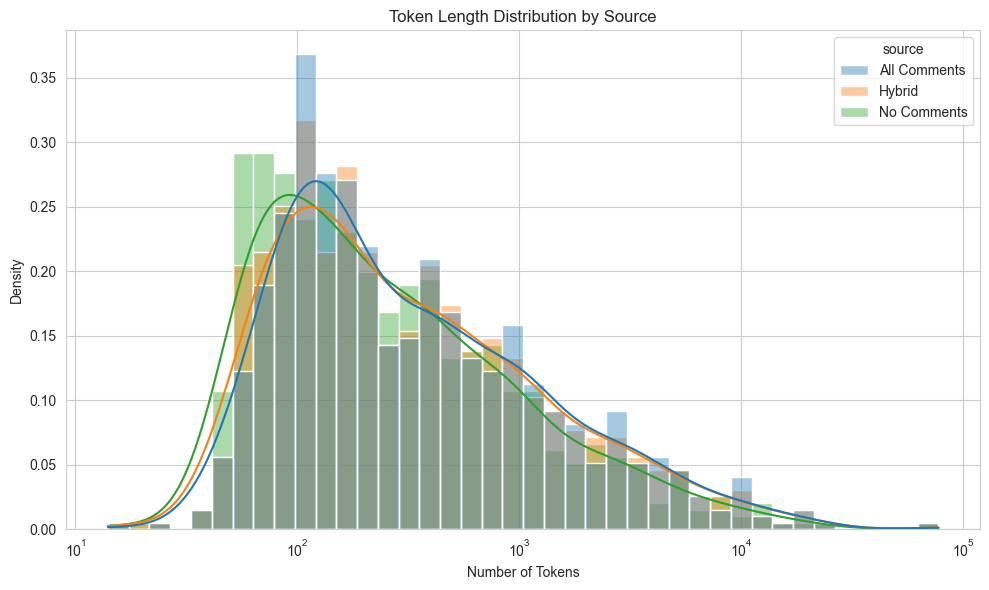

In [53]:
combined_Df = pd.concat([
    nomod_tok_df.assign(source="All Comments"),
    hybrid_tok_df.assign(source="Hybrid"),
    nocomment_tok_df.assign(source="No Comments")
])

sns.set_style("whitegrid") 
plt.figure(figsize=(10,6))
sns.histplot(data=combined_Df, x="n_tokens", hue="source", kde=True, bins=40, alpha=0.4, log_scale=True, stat="density")
plt.title("Token Length Distribution by Source")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


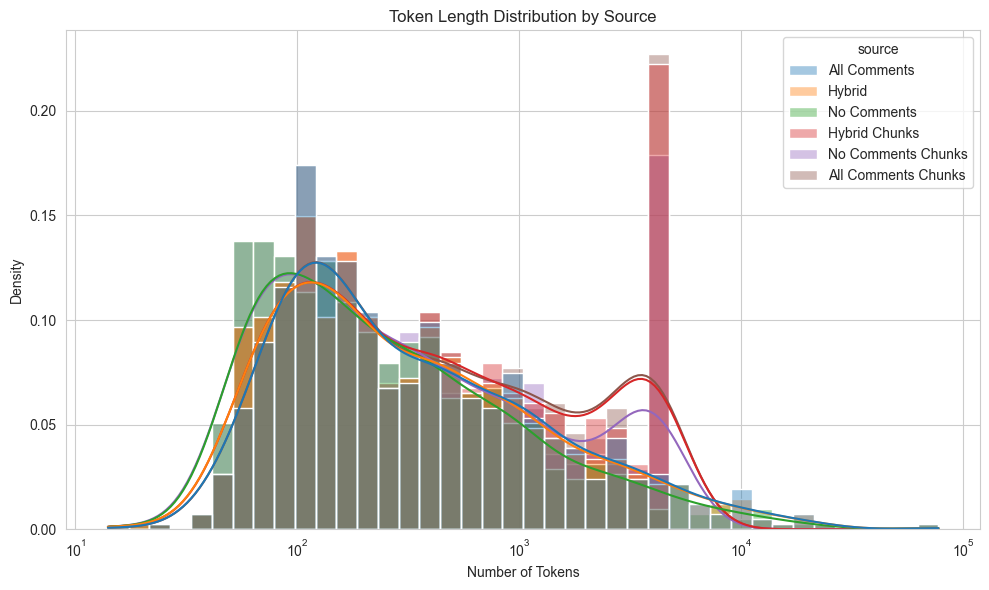

In [54]:
all_combined_df = pd.concat([
    nomod_tok_df.assign(source="All Comments"),
    hybrid_tok_df.assign(source="Hybrid"),
    nocomment_tok_df.assign(source="No Comments"),
    hybrid_chunk_df.assign(source="Hybrid Chunks"),
    nocomment_chunk_df.assign(source="No Comments Chunks"),
    nomod_chunk_df.assign(source="All Comments Chunks"),
])

plt.figure(figsize=(10,6))
sns.histplot(data=all_combined_df, x="n_tokens", hue="source", kde=True, bins=40, alpha=0.4, log_scale=True, stat="density")
plt.title("Token Length Distribution by Source")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

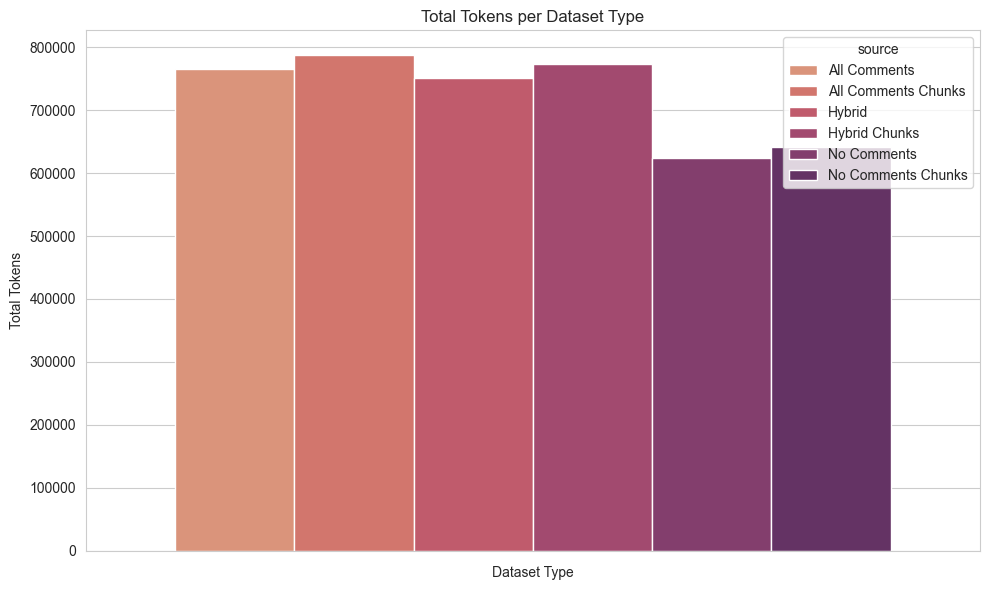

                source  n_tokens
0         All Comments    764804
1  All Comments Chunks    787332
2               Hybrid    751192
3        Hybrid Chunks    773720
4          No Comments    624732
5   No Comments Chunks    642140


In [55]:
plt.figure(figsize=(10,6))
sns.barplot(data=combined_df.groupby("source")["n_tokens"].sum().reset_index(), hue="source", y="n_tokens", palette="flare", legend=True)
plt.title("Total Tokens per Dataset Type")
plt.ylabel("Total Tokens")
plt.xlabel("Dataset Type")
#plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
print(combined_df.groupby("source")["n_tokens"].sum().reset_index())

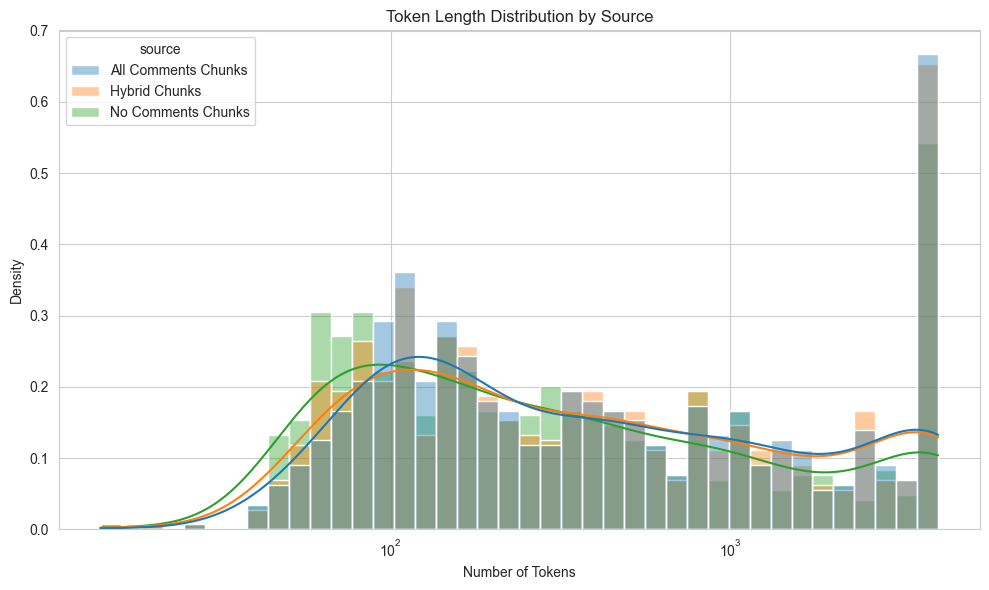

In [ ]:
combined_chunk_df = pd.concat([
    nomod_chunk_df.assign(source="All Comments Chunks"),
    hybrid_chunk_df.assign(source="Hybrid Chunks"),
    nocomment_chunk_df.assign(source="No Comments Chunks")
])

plt.figure(figsize=(10,6))
sns.histplot(data=combined_chunk_df, x="n_tokens", hue="source", kde=True, bins=40, alpha=0.4, log_scale=True, stat="density")
plt.title("Token Length Distribution by Source")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()   